# Example 2 -- Regular Grid

# Let's make a simple model in the shape of the Kingdom of Saudi Arabia

In [1]:
# import Python packages used for this example
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon, LineString
import flopy
import geopandas as gp

## Let's read in a simplified shapefile of the boundaries for the Kingdom of Saudi Arabia

<Axes: >

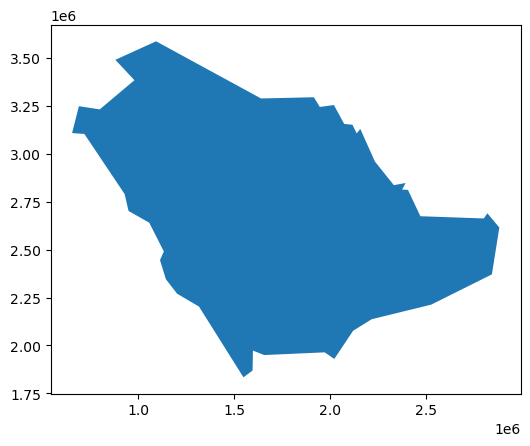

In [2]:
domaingdf = gp.read_file('./data/ksa_outline.json').to_crs(8836)
domaingdf.plot()

In [3]:
bounds = domaingdf.bounds
bounds

,minx,miny,maxx,maxy
0,654302.950403,1.833822e+06,2.884654e+06,3.587858e+06


## We need the bounds to create a grid. We can also choose how to discretize space and time (assuming steady-state for this example)

In [4]:
domain =domaingdf.geometry.values[0]


In [5]:
# define the model grid
Lx = bounds.maxx.values[0]-bounds.minx.values[0]
Ly = bounds.maxy.values[0]- bounds.miny.values[0]
nlay = 1
nrow = 60
delc = np.ceil(Ly / nrow) * np.ones(nrow, dtype=float)
ncol = np.ceil(Lx / delc[0]).astype(int)
delr = delc[0] * np.ones(ncol, dtype=float)
top = 50 * np.ones((nrow, ncol), dtype=float)
botm = -5000 * np.ones((nlay, nrow, ncol), dtype=float)

# create a flopy grid object, which can be used for intersections
sg = flopy.discretization.StructuredGrid(
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm
)


## Note that this is not registered to the specific location on the earth

(542785.3871048067, 2996171.7796644378, 1746119.7411307925, 3675559.3567427075)

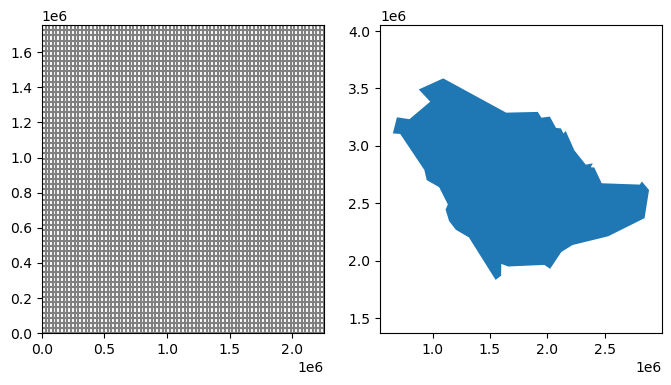

In [6]:
fig,ax = plt.subplots(1,2,figsize=(8,4))
sg.plot(ax=ax[0])
domaingdf.plot(ax=ax[1])
plt.axis('equal')

## We can register it, using the local bounds of the original shape

(542785.3871048067, 2996171.7796644378, 1746119.7411307925, 3675559.3567427075)

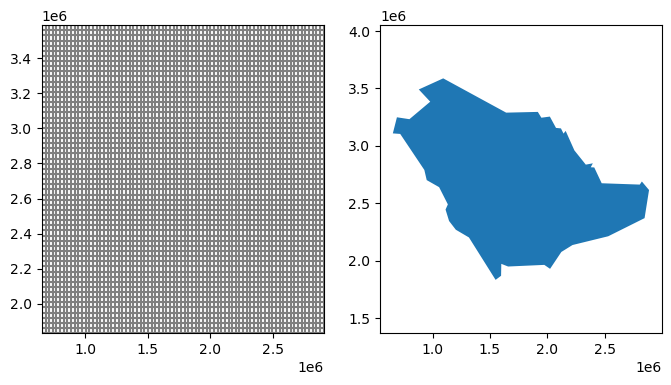

In [7]:
sg.set_coord_info(xoff=bounds.minx.values[0],
    yoff=bounds.miny.values[0],angrot=0, crs=8836)
fig,ax = plt.subplots(1,2,figsize=(8,4))
sg.plot(ax=ax[0])
domaingdf.plot(ax=ax[1])
plt.axis('equal')

## Now we set `idomain` - special array to indicate which cells are active and which are not

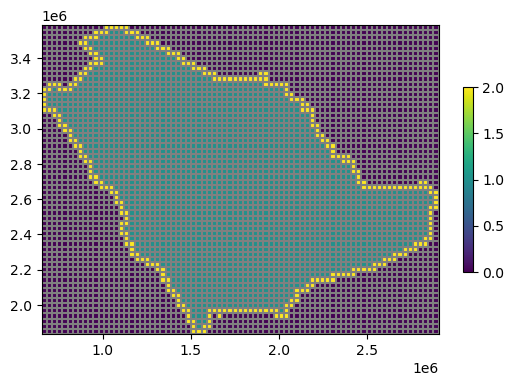

In [8]:
# create an idomain indicator array
idomain = np.zeros((nlay, nrow, ncol), dtype=int)
gi = flopy.utils.GridIntersect(sg)

# inside domain polygon (idomain = 1)
ixp = gi.intersect(domain)
for i, j in ixp["cellids"]:
    idomain[:, i, j] = 1

# touching domain polygon (idomain = 2)
ls = LineString([p for p in domain.exterior.coords])    
ixl = gi.intersect(ls)
for i, j in ixl["cellids"]:
    idomain[:, i, j] = 2
    
pmv = flopy.plot.PlotMapView(modelgrid=sg)
pmv.plot_grid()
cb = pmv.plot_array(idomain)
plt.colorbar(cb, shrink=.5)

# We need to make all the model components as python objects

## First the overall simulation (including timing)

In [9]:
# create the flopy representation of the MODFLOW simulation
ws = './ex2'
name = 'mymodel'
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name='mf6')
tdis = flopy.mf6.ModflowTdis(sim, nper=1, perioddata=[1,1,1])

## Next, need to make a solver and a `gwf` model (for groundwater flow)

In [10]:
ims = flopy.mf6.ModflowIms(sim, print_option="all", inner_maximum=100)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)

## Finally, the other packages including:
  - Discretization (spatial information: `dis`)
  - Initial conditions (`ic`)
  - Hydraulic Conductivity properties (`npf`)
  - Constant head boundaries (`chd`)
  - recharge (`rch`)
  - Output control (`oc`)

In [11]:
dis = flopy.mf6.ModflowGwfdis(
    gwf, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc, 
    top=top, botm=botm, idomain=idomain)
ic = flopy.mf6.ModflowGwfic(gwf, strt=top)
npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True, icelltype=1)
chdspd = [[(0, i, j), 1.] for i, j in ixl["cellids"]]
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdspd)
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.0001)
oc = flopy.mf6.ModflowGwfoc(gwf,
                            budget_filerecord=f"{name}.bud",
                            head_filerecord=f"{name}.hds",
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

In [12]:
# write the MODFLOW input files
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mymodel...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 290 based on size of stress_period_data
    writing package rcha_0...
    writing package oc...


In [13]:
# run the MODFLOW simulation
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../../.local/share/flopy/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.2 06/28/2023

   MODFLOW 6 compiled Jul 05 2023 20:29:14 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor th

(True, [])

## now let's load up the head and budget information to visualize

In [14]:
# load the output from the simulation
head = gwf.output.head().get_data()
bud = gwf.output.budget()
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

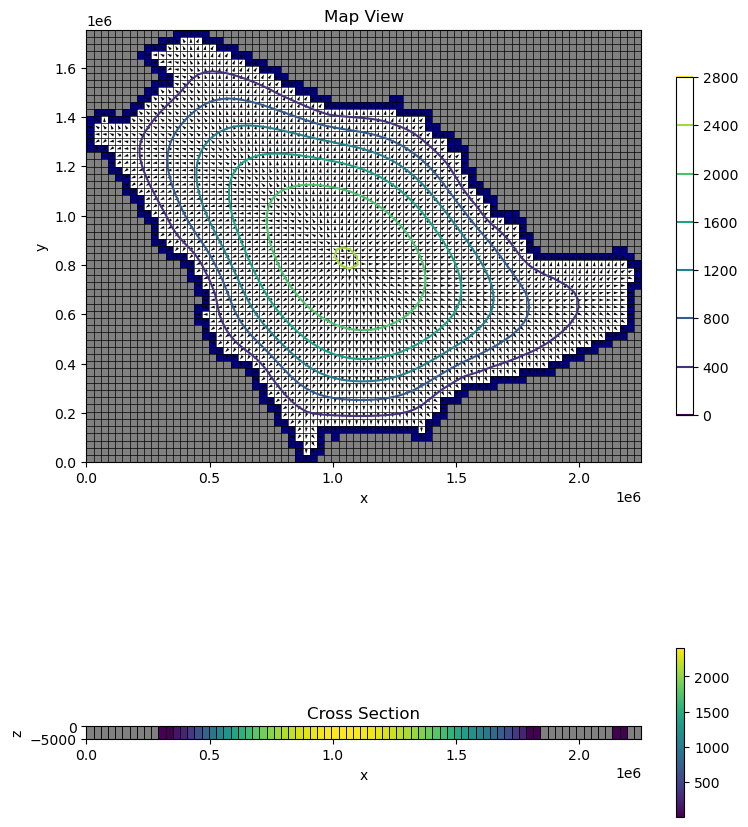

In [15]:
# create a plot of the model results
fig, axes = plt.subplots(2, 1, figsize=(8, 11))
ax = axes[0]
ax.set_title("Map View")
ax.set_aspect(1)
ax.set_xlabel("x")
ax.set_ylabel("y")
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
pmv.plot_bc(ftype="CHD")
pmv.plot_inactive(color_noflow="gray")
pmv.plot_grid(color="black", linewidth=0.5)
pmv.plot_vector(qx, qy, normalize=True, color="black", istep=1, jstep=1)
h = pmv.contour_array(head)
plt.colorbar(h, shrink=.6)

ax = axes[1]
ax.set_title("Cross Section")
ax.set_aspect(10.)
ax.set_xlabel("x")
ax.set_ylabel("z")
pxs = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"row": int(nrow/2)})
pxs.plot_inactive(color_noflow="gray")
pxs.plot_bc(ftype="CHD")
h2 = pxs.plot_array(head, head=head)
pxs.plot_grid(color="black", linewidth=0.5)
plt.colorbar(h2, shrink=.3)
plt.tight_layout()